# Machine Learning (second part): Intermediate report

*Write your name and your student ID below.*

In [ ]:
# Modify these lines.
student_name = 'Aoyu Li'
student_id = '20M30730'

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following four problems, and submit the notebook file (`.ipynb`) on OCW. **We do not accept a report in other formats (e.g., Word, PDF, HTML)**. You can use any deep learning library for completing this report. Write a code at the specified cell in the notebook. You can add more cells if necessary. Submit this report even if you cannot solve all problems.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearning/blob/master/notebook/binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearning/blob/master/notebook/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in accuracy.

One can use the same code shown in the lecture. Write a code here and show the output.

Prepare data set.

In [1]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

Model.

In [2]:
def softmax(x):
    # We subtract the maximum value to prevent overflow and underflow problems, 
    # (result of softmax are invariant even if we add/subtract a constant)
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 785)
Ytrain = label_to_onehot(data['train_y'], 10)   # (60000 x 10)
Xtest = image_to_vector(data['test_x'])         # (10000 x 785)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

W = np.random.randn(10, 28*28+1)                # (10 x 785)

eta = 0.001
for t in range(100):
    loss = 0.
    num_correct_train = 0
    
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        loss += -np.log(y_pred[np.argmax(y)])
        W += np.outer(eta * (y - y_pred), x)    # np.outer: out[i,j] = a[i]*b[j]
        if np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
    
    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
            
    print('#{}: loss={:.2f}, train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        loss / len(Ytrain),
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

#0: loss=2.60, train_accuracy=0.6062, test_accuracy=0.7665
#1: loss=1.08, train_accuracy=0.7879, test_accuracy=0.8197
#2: loss=0.86, train_accuracy=0.8242, test_accuracy=0.8402
#3: loss=0.75, train_accuracy=0.8413, test_accuracy=0.8519
#4: loss=0.69, train_accuracy=0.8525, test_accuracy=0.8590
#5: loss=0.64, train_accuracy=0.8606, test_accuracy=0.8652
#6: loss=0.60, train_accuracy=0.8663, test_accuracy=0.8694
#7: loss=0.57, train_accuracy=0.8713, test_accuracy=0.8726
#8: loss=0.55, train_accuracy=0.8750, test_accuracy=0.8763
#9: loss=0.53, train_accuracy=0.8776, test_accuracy=0.8787
#10: loss=0.51, train_accuracy=0.8803, test_accuracy=0.8818
#11: loss=0.50, train_accuracy=0.8824, test_accuracy=0.8838
#12: loss=0.48, train_accuracy=0.8848, test_accuracy=0.8854
#13: loss=0.47, train_accuracy=0.8865, test_accuracy=0.8869
#14: loss=0.46, train_accuracy=0.8885, test_accuracy=0.8892
#15: loss=0.45, train_accuracy=0.8899, test_accuracy=0.8908
#16: loss=0.44, train_accuracy=0.8918, test_accura

Test accuracy on the test set is about 91.61%.

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [32]:
for x, y in zip(Xtest, Ytest):
    y_pred = np.argmax(np.dot(W, x))
    if y_pred != y:
        print(x[:784].reshape(28, 28))
        break

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (for easy three examples) and $y_n \neq \hat{y}_n$ (for confusing three examples).

For each example, please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$ together with the image $x_n$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images, in other words, for six images in total).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [33]:
easy = []
confusing = []
true = []
pred = []
p_true = []
p_pred = []
index_e = 0
index_c = 0

for n in range(3):
    p_max_e = 0
    for i in range(len(Ytest)):
        y_pred = np.argmax(np.dot(W, Xtest[i]))
        if y_pred == Ytest[i]:
            p_soft = np.max(softmax(np.dot(W, Xtest[i])))
            if p_max_e < p_soft and i not in easy:
                p_max_e = p_soft
                index_e = i
                y_e = y_pred
    easy.append(index_e)
    true.append(Ytest[index_e])
    pred.append(y_e)
    p_pred.append(p_max_e)
    
for n in range(3):
    p_max_c = 0
    for i in range(len(Ytest)):
        y_pred = np.argmax(np.dot(W, Xtest[i]))
        if y_pred != Ytest[i]:
            p_soft = np.max(softmax(np.dot(W, Xtest[i])))
            if p_max_c < p_soft and i not in confusing:
                p_max_c = p_soft
                index_c = i
                y_c = y_pred
    confusing.append(index_c)
    true.append(Ytest[index_c])
    pred.append(y_c)
    p_true.append(softmax(np.dot(W, Xtest[index_c]))[Ytest[index_c]])
    p_pred.append(p_max_c)

Top-3 easy:

True digit: 0; Prediction: 0 (P = 0.9999999997582945)


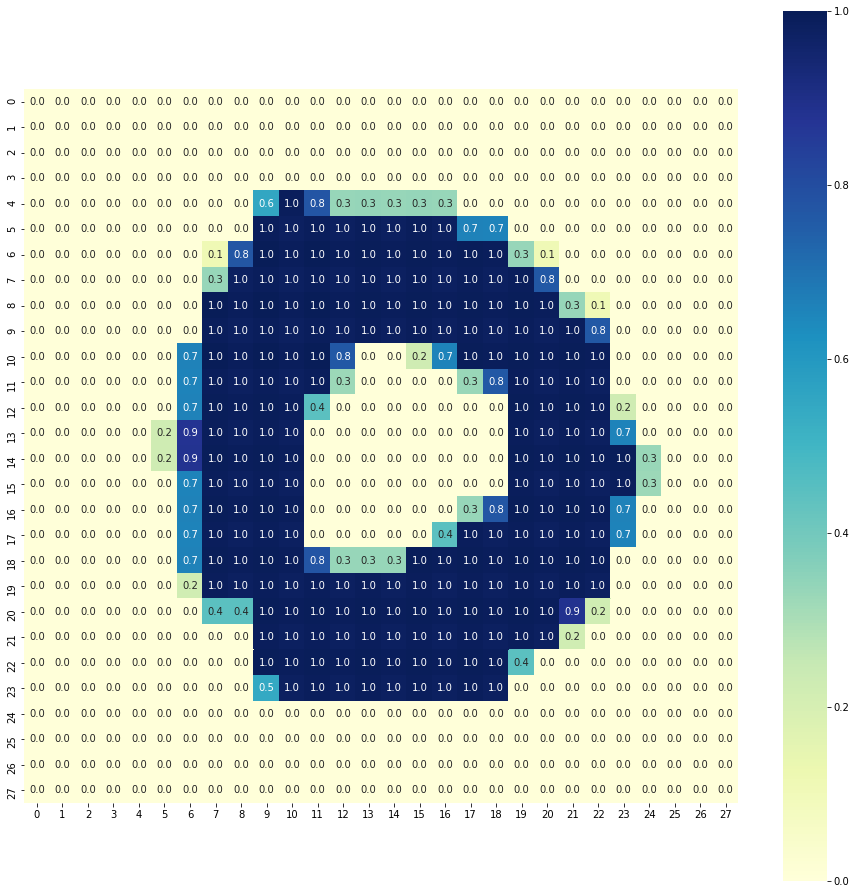

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

print('True digit: {}; Prediction: {} (P = {})'.format(
    true[0],
    pred[0],
    p_pred[0]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][easy[0]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

True digit: 0; Prediction: 0 (P = 0.9999999996722049)


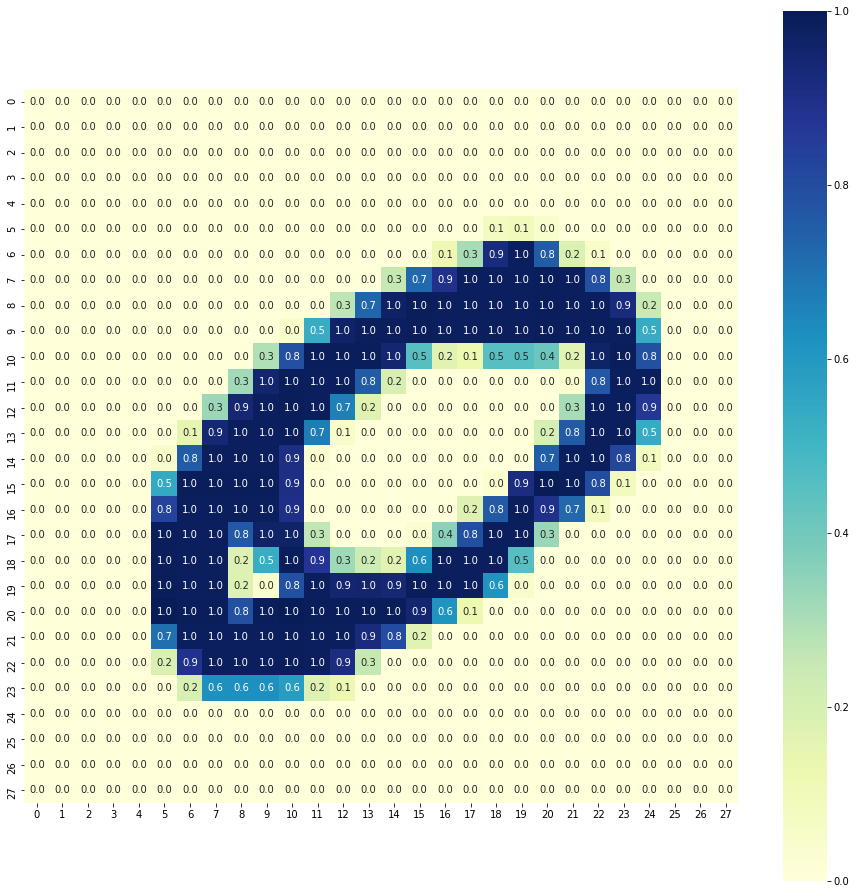

In [24]:
print('True digit: {}; Prediction: {} (P = {})'.format(
    true[1],
    pred[1],
    p_pred[1]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][easy[1]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

True digit: 0; Prediction: 0 (P = 0.9999999996188929)


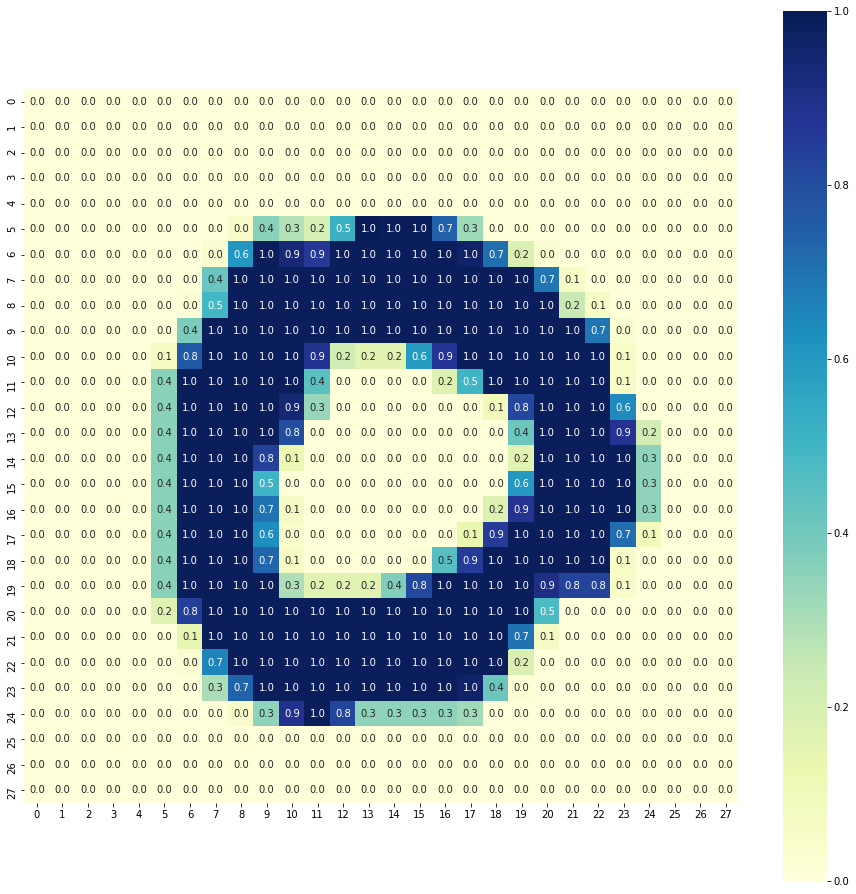

In [25]:
print('True digit: {}; Prediction: {} (P = {})'.format(
    true[2],
    pred[2],
    p_pred[2]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][easy[2]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

Top-3 confusing:

True digit: 2 (P = 3.3123658916667025e-06); Prediction: 7 (P = 0.9999626178795994)


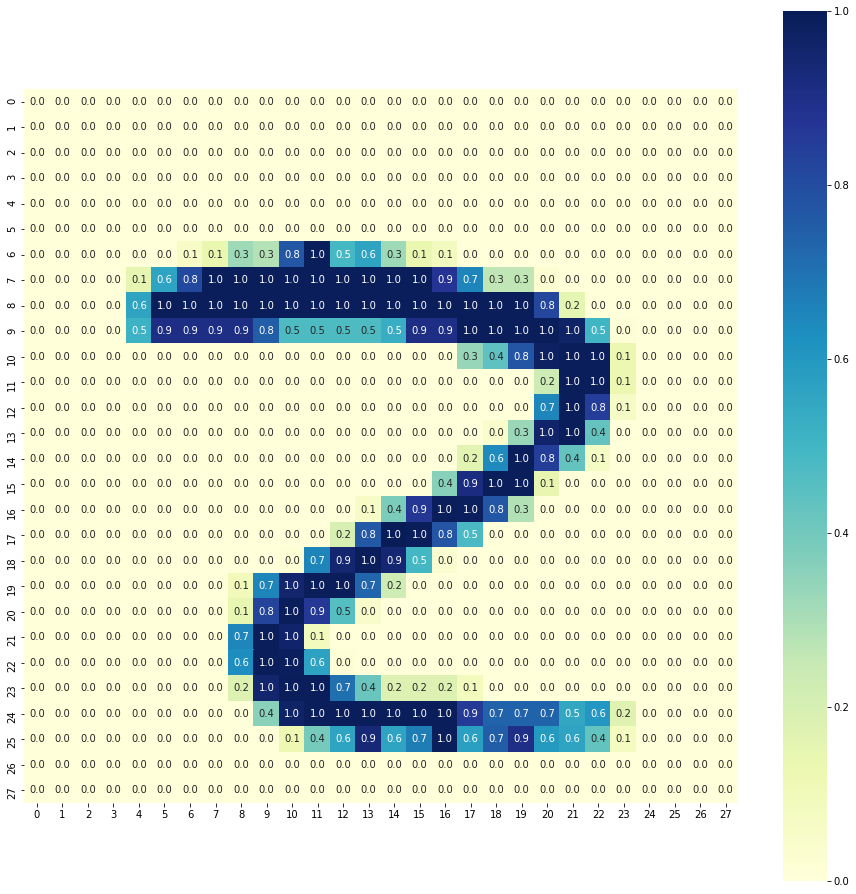

In [34]:
print('True digit: {} (P = {}); Prediction: {} (P = {})'.format(
    true[3],
    p_true[0],
    pred[3],
    p_pred[3]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][confusing[0]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

True digit: 2 (P = 4.4508008568100983e-07); Prediction: 4 (P = 0.9999071481902981)


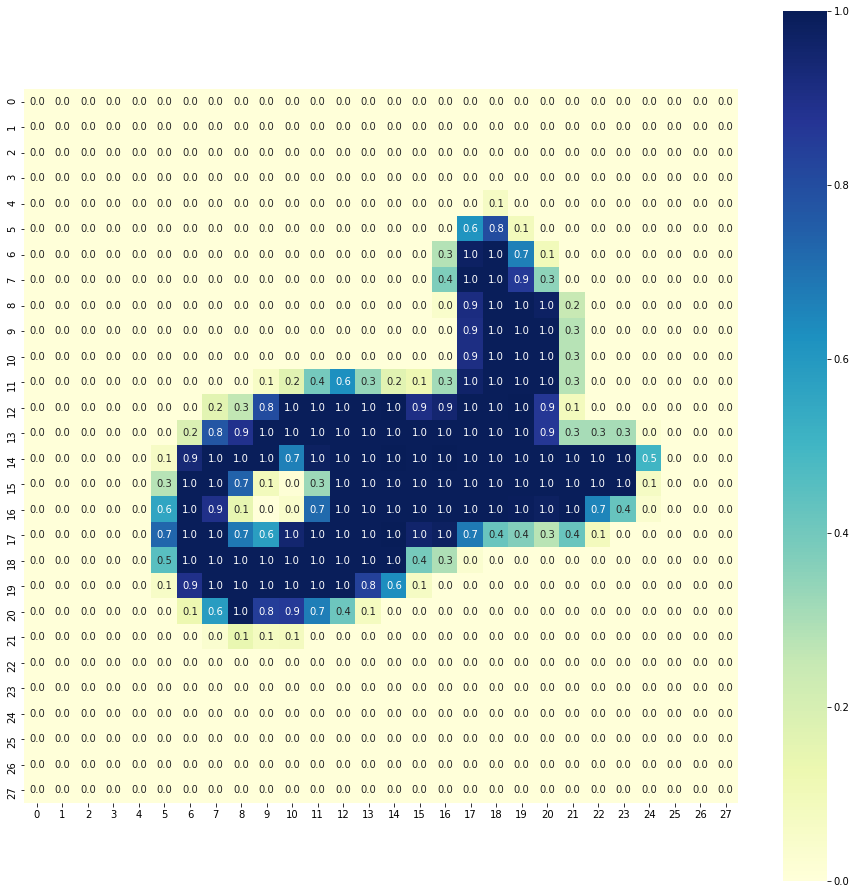

In [30]:
print('True digit: {} (P = {}); Prediction: {} (P = {})'.format(
    true[4],
    p_true[1],
    pred[4],
    p_pred[4]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][confusing[1]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

True digit: 8 (P = 2.5924000021618938e-05); Prediction: 4 (P = 0.9998989977553631)


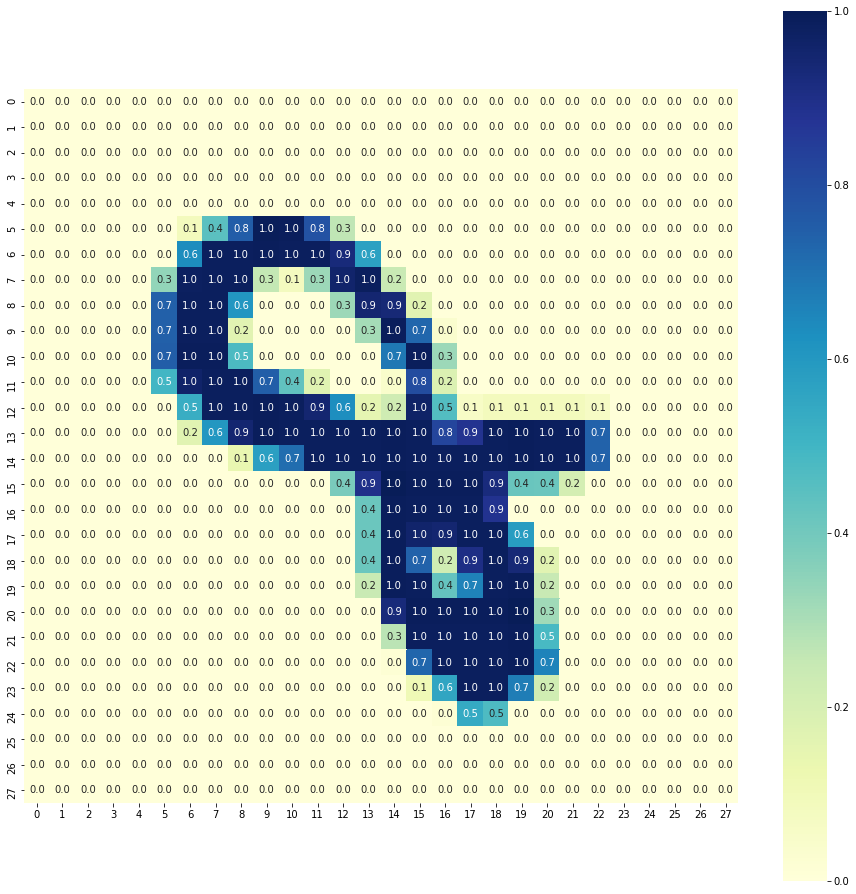

In [31]:
print('True digit: {} (P = {}); Prediction: {} (P = {})'.format(
    true[5],
    p_true[2],
    pred[5],
    p_pred[5]
))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(data['test_x'][confusing[2]], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## 4. Recognize your handwritten digits

Prepare three image files each of which presents a digit written by you. For each image, apply the MNIST model you trained, and show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ (10-dimensional vector) for all possible digits as well as the image itself.

Please refer to [this notebook](https://colab.research.google.com/notebooks/io.ipynb) about how to upload a file to Google Colaboratory.

### Image #1

Write the code to show the image #1 here.

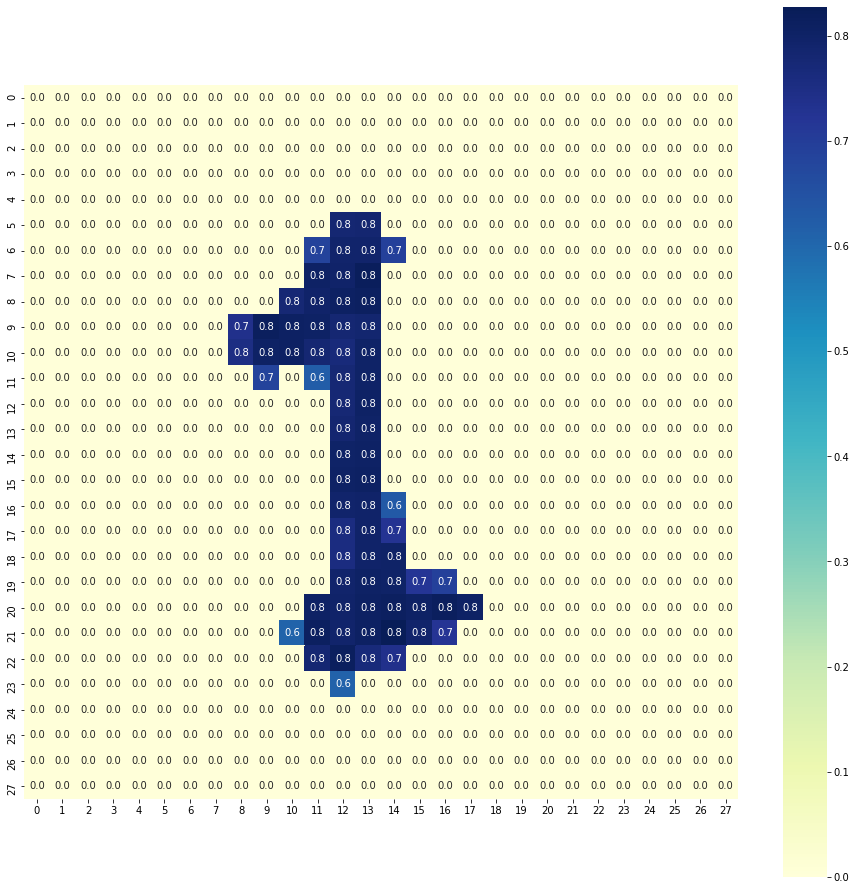

In [77]:
from PIL import Image

def make_set(path):
    img = Image.open(path).convert('L')
    img = img.resize((28,28), Image.ANTIALIAS)
    img2arr = np.asarray(img, dtype=np.float32)
    return (255 - np.where(img2arr > 100, 255, img2arr)) / 255.0

f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(make_set('test_1.JPG'), annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

In [97]:
test1 = np.hstack([make_set('test_1.JPG').reshape(-1), np.ones(1)])
print('test_1.JPG has {} probability to be predicted as #1'.format(softmax(np.dot(W, test1))[1]))
print('estimate result is', np.argmax(np.dot(W, test1)))

test_1.JPG has 0.009482950757130681 probability to be predicted as #1
estimate result is 5


### Image #2

Write the code to show the image #2 here.

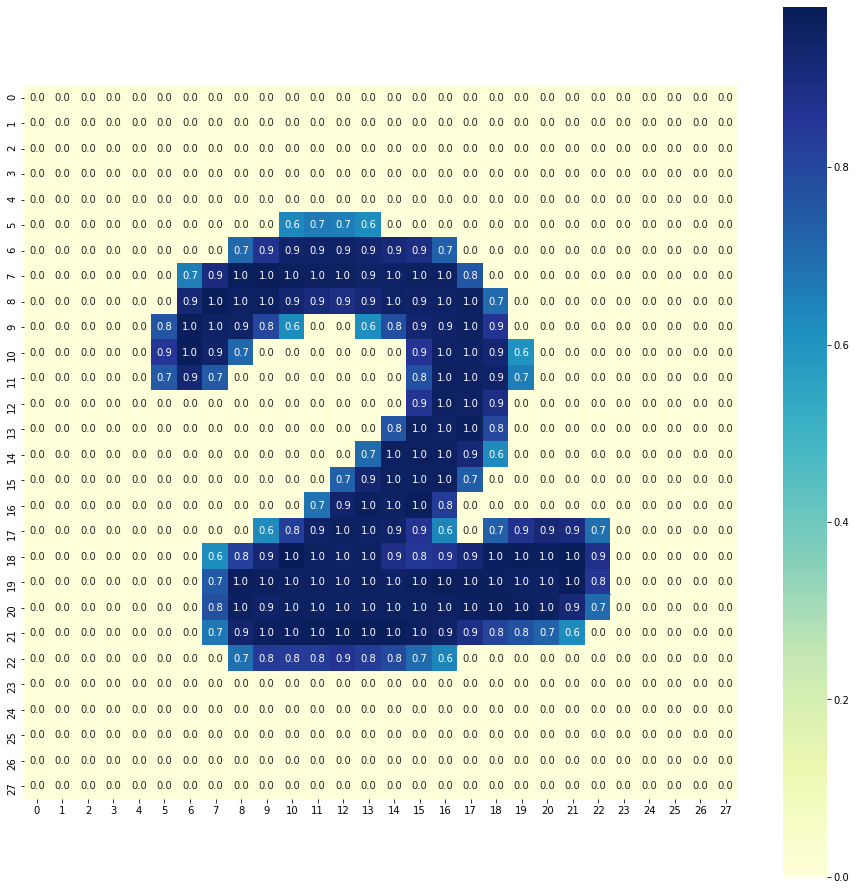

In [71]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(make_set('test_2.JPG'), annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.


In [98]:
test2 = np.hstack([make_set('test_2.JPG').reshape(-1), np.ones(1)])
print('test_2.JPG has {} probability to be predicted as #2'.format(softmax(np.dot(W, test2))[2]))
print('estimate result is', np.argmax(np.dot(W, test2)))

test_2.JPG has 0.9999749863247772 probability to be predicted as #2
estimate result is 2


### Image #3

Write the code to show the image #3 here.

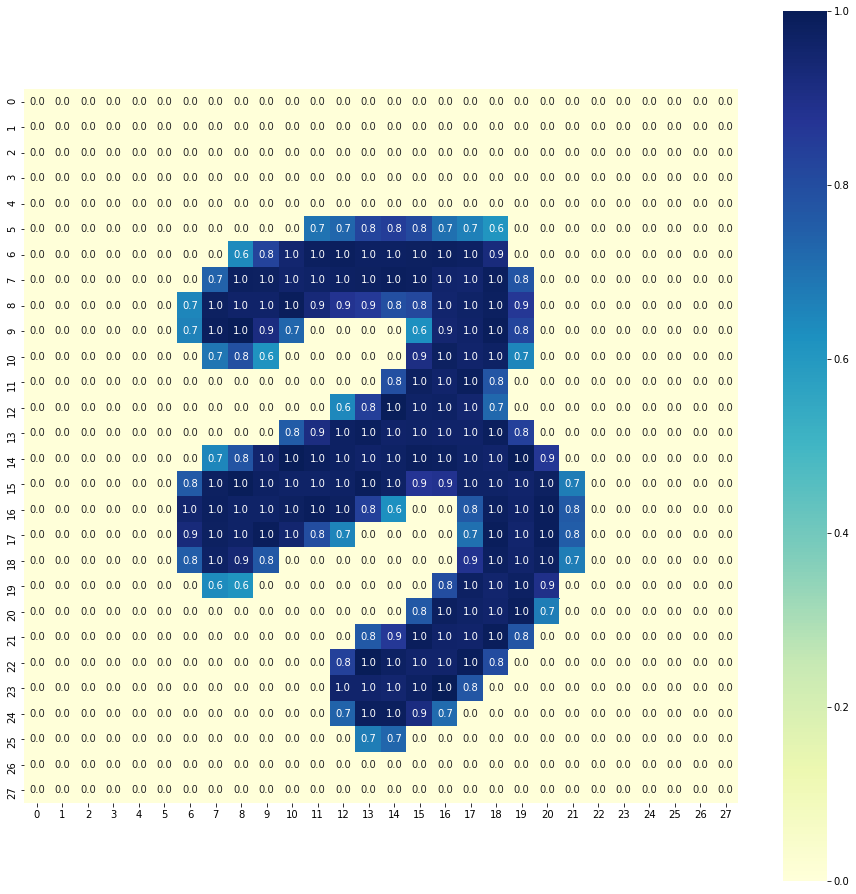

In [73]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(make_set('test_3.JPG'), annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

In [99]:
test3 = np.hstack([make_set('test_3.JPG').reshape(-1), np.ones(1)])
print('test_3.JPG has {} probability to be predicted as #3'.format(softmax(np.dot(W, test3))[3]))
print('estimate result is', np.argmax(np.dot(W, test3)))

test_3.JPG has 0.997848474291914 probability to be predicted as #3
estimate result is 3
